In [1]:
import argparse
import numpy as np
import time

import torch
import torch.optim as optim

from utils import load_data,svdApprox,nmi_score,normalize
#from GNN import GraphNeuralNet
import pycombo
import networkx as nx

import torch.nn as nn
import torch.nn.functional as F
from layers import GraphNN1, GraphNN1_h, GraphNN2, InnerProduct
from utils import doublerelu


import matplotlib.pyplot as plt 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)

In [4]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=20001,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.00001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=5,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [5]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [6]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphNN1(Module):

    def __init__(self, batch_size, in_features, out_features, fixed):
        super(GraphNN1, self).__init__()

        self.batch_size = batch_size
        self.in_features = in_features
        self.out_features = out_features
        self.fixed = fixed
        weight0_eye = torch.FloatTensor(torch.eye(in_features,out_features))
        weight0_eye = weight0_eye.reshape((1, in_features, out_features))
        weight0_eye = weight0_eye.repeat(batch_size, 1, 1)
        self.weight0 = Parameter(weight0_eye)
        self.weight1 = Parameter(torch.zeros(batch_size, in_features, out_features))


    def forward(self, input, adj):
        v1 = torch.bmm(input, self.weight0)
        v2 = torch.bmm(torch.bmm(adj, input),self.weight1)
        output = v1 + v2
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [7]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphNN2(Module):

    def __init__(self, batch_size, in_features, out_features, fixed):
        super(GraphNN2, self).__init__()

        self.batch_size = batch_size
        self.in_features = in_features
        self.out_features = out_features
        self.fixed = fixed
        weight0_eye = torch.FloatTensor(torch.eye(in_features,in_features))
        weight0_eye = weight0_eye.reshape((1, in_features, in_features))
        weight0_eye = weight0_eye.repeat(batch_size, 1, 1)
        weight0_rand = torch.empty(batch_size,in_features,out_features-in_features)
        torch.nn.init.xavier_uniform_(weight0_rand, gain=1.0)
        self.weight0 = Parameter(torch.cat((weight0_eye,weight0_rand),dim=2))
        self.weight1 = Parameter(torch.zeros(batch_size, in_features, out_features))


    def forward(self, input, adj):
        v1 = torch.bmm(input, self.weight0)
        v2 = torch.bmm(torch.bmm(adj, input),self.weight1)
        output = v1 + v2
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [8]:
class GNN1Layer(nn.Module):

    def __init__(self, batch_size, nfeat, hidden, ndim, fixed):
        super(GNN1Layer, self).__init__()

        self.batch_size = batch_size
        self.nfeat = nfeat
        if fixed:
            self.ndim = 2*ndim
            self.hidden = hidden
        else:
            self.ndim = 4*ndim
            self.hidden = 2*hidden
        self.fixed = fixed

        self.x1 = GraphNN1(batch_size, self.ndim, self.ndim, fixed)
        #self.x2 = GraphNN1(batch_size, self.hidden*self.ndim, self.ndim, fixed)
        
        self.reconstructions = InnerProduct(self.ndim)

    def forward(self, x, adj):

        #scale weights for sigmoid
        scale = 1000
        x = x/scale
        x = torch.sigmoid(x)
        x1 = doublerelu(self.x1(x, adj))
        x2 = torch.logit(x1)

        # rescale back to original weights
        x2 = x2*scale
        if self.fixed:
            mu = F.relu(self.reconstructions(x2))
            return mu, x2
        else:
            lr1, lr2 = torch.chunk(x2, chunks=2, dim=2)
            mu = F.relu(self.reconstructions(lr1))
            sigma = F.relu(self.reconstructions(lr2))
            return mu, sigma, x2

In [9]:
class GNN2Layer(nn.Module):

    def __init__(self, batch_size, nfeat, hidden, ndim, fixed):
        super(GNN2Layer, self).__init__()

        self.batch_size = batch_size
        self.nfeat = nfeat
        if fixed:
            self.ndim = 2*ndim
            self.hidden = hidden
        else:
            self.ndim = 4*ndim
            self.hidden = 2*hidden
        self.fixed = fixed

        self.x1 = GraphNN2(batch_size, self.ndim, self.hidden*self.ndim, fixed)
        self.x2 = GraphNN1(batch_size, self.hidden*self.ndim, self.ndim, fixed)
        
        self.reconstructions = InnerProduct(self.ndim)

    def forward(self, x, adj):

        #scale weights for sigmoid
        scale = 1000
        x = x/scale
        x = torch.sigmoid(x)
        x1 = doublerelu(self.x1(x, adj))
        x2 = doublerelu(self.x2(x1, adj))
        x2 = torch.logit(x2)

        # rescale back to original weights
        x2 = x2*scale
        if self.fixed:
            mu = F.relu(self.reconstructions(x2))
            return mu, x2
        else:
            lr1, lr2 = torch.chunk(x2, chunks=2, dim=2)
            mu = F.relu(self.reconstructions(lr1))
            sigma = F.relu(self.reconstructions(lr2))
            return mu, sigma, x2

In [10]:
def GraphNeuralNet(adj,dim,hidden,fixed,features,GNN):

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    adj_norm = torch.FloatTensor(np.array(adj_norm))

    # loss function
    criterion = torch.nn.GaussianNLLLoss()

    # NULL Model
    mu0 = adj.mean() * torch.ones(adj.shape[1:])
    sigma0 = adj.std() * torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))

    # Model and optimizer

    model = GNN(batch_size=adj.shape[0],
                nfeat=features.shape[1],
                hidden=hidden,
                ndim=dim,
                fixed=fixed)

    if args.cuda:
        model = model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()

    # Train model
    t_total = time.time()

    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)


    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()

        if fixed:
            mu,lr = model(features, adj_norm)
            with torch.no_grad():
                mse = torch.nn.MSELoss()
                mseloss = mse(torch.flatten(mu), torch.flatten(adj))
                sig = torch.sqrt(mseloss)
            sigma = sig * torch.ones(adj.shape, requires_grad=True).cuda()
        else:
            mu, sigma,lr = model(features, adj_norm)

        loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma)))
        loss.backward(retain_graph=True)

        optimizer.step()

        if epoch == 0:
            best_loss = loss
            best_lr = lr
            best_mu = mu
            if fixed:
                best_sig = sig
        else:
            if loss < best_loss:
                best_loss = loss
                best_lr = lr
                best_mu = mu
                if fixed:
                    best_sig = sig

        if epoch % 5000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    if fixed:
        return best_lr, best_sig, best_mu, best_loss
    else:
        return best_lr, best_mu, best_loss

In [11]:
def HGNN(adj,dim,hidden,fixed):
    
    #partition using pycombo
    G = nx.from_numpy_matrix(np.array(adj[0]))
    partition = pycombo.execute(G, random_seed = args.seed)
    
    #get binary matrix of the partition and inverse community disaggregation mapping
    nb_community = max(list(partition[0].values())) + 1
    communities =  np.array(list(partition[0].values())).reshape(-1)
    C = np.eye(nb_community)[communities]
    C = torch.Tensor(C).unsqueeze(0)
    
    #perform svd on orig network
    _,sig,_,svd_embedx,svd_embedy = svdApprox(adj,dim)
    svd_embed = torch.cat([svd_embedx,svd_embedy],dim=1)
    if not fixed:
        svd_sigma = torch.ones(svd_embed.shape) * torch.sqrt(sig / dim)
        svd_embed = torch.cat([svd_embed,svd_sigma],dim=1)

    features = torch.FloatTensor(svd_embed)
    features = features.unsqueeze(0)
    
    

    if fixed:
        embed, sigma, mu, loss = GraphNeuralNet(adj=adj, dim=dim, hidden=hidden, fixed=True, features=features, GNN=GNN1Layer)
        return embed, sigma, mu, loss
    else:
        embed, mu, loss = GraphNeuralNet(adj=adj, dim=dim, hidden=hidden, fixed=False, features=features, GNN=GNN1Layer)
        return embed, mu, loss
    

In [12]:
def HGNN_embed(adj,dim):
    
    print("\nFixed Sigma dim {}\n".format(dim))
    
    lr,sig,fix_mu,fix_loss = HGNN(adj,dim,4,True)
    
    sigma = torch.ones(lr.shape).cuda() * torch.sqrt(sig/dim)
    features = torch.cat([lr,sigma],dim=2).cpu().detach()
    features = torch.Tensor(features)
    

    print("\nFlexible Sigma dim {}\n".format(dim))
    embed, flex_mu, flex_loss = GraphNeuralNet(adj=adj, dim=dim, hidden=4, fixed=False, features=features, GNN=GNN1Layer)
    
    print("\n2 Layer dim {}\n".format(dim))
    embed, flex_mu, flex_loss = GraphNeuralNet(adj=adj, dim=dim, hidden=4, fixed=False, features=embed.detach(), GNN=GNN2Layer)
    
    
    return embed, fix_mu, flex_mu, fix_loss, flex_loss
    

In [13]:
fix_loss = []
nonfix_loss = []
svd_loss = []
svdrelu_loss = []
nmi_fix = []
nmi_nonfix = []
nmi_svd = []
nmi_svdrelu = []
dims = [x for x in range(1,15)]

for dim in dims:
    
    fixembed, fix_mu, flex_mu, fixloss, flexloss = HGNN_embed(adj,dim)
    fix_loss.append(fixloss)
    nmi_fix.append(nmi_score(adj[0],fix_mu.reshape(adj.shape[1:]).cpu().detach()))
    nonfix_loss.append(flexloss)
    nmi_nonfix.append(nmi_score(adj[0],flex_mu.reshape(adj.shape[1:]).cpu().detach()))
    
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim)
    svd_loss.append(loss)
    nmi_svd.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).cpu().detach()))
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim,relu=True)
    svdrelu_loss.append(loss)
    nmi_svdrelu.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).cpu().detach()))


Fixed Sigma dim 1

Epoch: 0001 loss: 10.95440483 time: 0.5421s
Epoch: 5001 loss: 10.95440388 time: 0.0000s
Epoch: 10001 loss: 10.95440388 time: 0.0099s
Epoch: 15001 loss: 10.95440388 time: 0.0020s
Epoch: 20001 loss: 10.95440388 time: 0.0020s
Optimization Finished!
Total time elapsed: 48.8027s

Flexible Sigma dim 1

Epoch: 0001 loss: 10.95440388 time: 0.0020s
Epoch: 5001 loss: 8.88333511 time: 0.0020s
Epoch: 10001 loss: 8.83050346 time: 0.0010s
Epoch: 15001 loss: 8.79169750 time: 0.0020s
Epoch: 20001 loss: 8.68842697 time: 0.0010s
Optimization Finished!
Total time elapsed: 31.4385s

2 Layer dim 1

Epoch: 0001 loss: 8.68842983 time: 0.0020s
Epoch: 5001 loss: 8.53100014 time: 0.0020s
Epoch: 10001 loss: 8.43688393 time: 0.0030s
Epoch: 15001 loss: 8.33622456 time: 0.0020s
Epoch: 20001 loss: 8.08775330 time: 0.0030s
Optimization Finished!
Total time elapsed: 43.1034s

Fixed Sigma dim 2

Epoch: 0001 loss: 10.72826767 time: 0.0020s
Epoch: 5001 loss: 10.72824192 time: 0.0020s
Epoch: 10001 loss

Epoch: 5001 loss: 7.90142393 time: 0.0000s
Epoch: 10001 loss: 7.90142393 time: 0.0020s
Epoch: 15001 loss: 7.90142393 time: 0.0020s
Epoch: 20001 loss: 7.90142393 time: 0.0020s
Optimization Finished!
Total time elapsed: 34.3333s

2 Layer dim 10

Epoch: 0001 loss: 7.90142202 time: 0.0030s
Epoch: 5001 loss: 7.90142202 time: 0.0020s
Epoch: 10001 loss: 7.90142202 time: 0.0020s
Epoch: 15001 loss: 7.88290310 time: 0.0030s
Epoch: 20001 loss: 7.88290310 time: 0.0030s
Optimization Finished!
Total time elapsed: 47.0455s

Fixed Sigma dim 11

Epoch: 0001 loss: 9.57401943 time: 0.0030s
Epoch: 5001 loss: 9.56044197 time: 0.0020s
Epoch: 10001 loss: 9.55696583 time: 0.0020s
Epoch: 15001 loss: 9.55432034 time: 0.0020s
Epoch: 20001 loss: 9.55202293 time: 0.0020s
Optimization Finished!
Total time elapsed: 42.1306s

Flexible Sigma dim 11

Epoch: 0001 loss: 9.55202389 time: 0.0030s
Epoch: 5001 loss: 7.76648808 time: 0.0020s
Epoch: 10001 loss: 7.76648808 time: 0.0020s
Epoch: 15001 loss: 7.76648808 time: 0.001

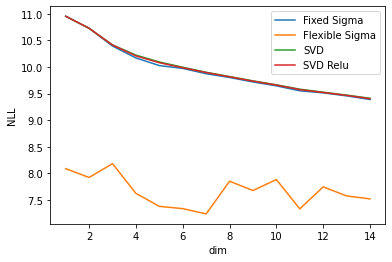

In [14]:
plt.plot(dims,fix_loss,label="Fixed Sigma")
plt.plot(dims,nonfix_loss,label="Flexible Sigma")
plt.plot(dims,svd_loss,label="SVD")
plt.plot(dims,svdrelu_loss,label="SVD Relu")
plt.xlabel("dim")
plt.ylabel("NLL")
plt.legend()